Lambda School Data Science

*Unit 4, Sprint 3, Module 3*

---

# Autoencoders

> An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner.[1][2] The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”. Along with the reduction side, a reconstructing side is learnt, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name. 

## Learning Objectives
*At the end of the lecture you should be able to*:
* <a href="#p1">Part 1</a>: Describe the componenets of an autoencoder
* <a href="#p2">Part 2</a>: Train an autoencoder
* <a href="#p3">Part 3</a>: Apply an autoencoder to a basic information retrieval problem

__Problem:__ Is it possible to automatically represent an image as a fixed-sized vector even if it isn’t labeled?

__Solution:__ Use an autoencoder

Why do we need to represent an image as a fixed-sized vector do you ask? 

* __Information Retrieval__
    - [Reverse Image Search](https://en.wikipedia.org/wiki/Reverse_image_search)
    - [Recommendation Systems - Content Based Filtering](https://en.wikipedia.org/wiki/Recommender_system#Content-based_filtering)
* __Dimensionality Reduction__
    - [Feature Extraction](https://www.kaggle.com/c/vsb-power-line-fault-detection/discussion/78285)
    - [Manifold Learning](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction)

We've already seen *representation learning* when we talked about word embedding modelings during our NLP week. Today we're going to achieve a similiar goal on images using *autoencoders*. An autoencoder is a neural network that is trained to attempt to copy its input to its output. Usually they are restricted in ways that allow them to copy only approximately. The model often learns useful properties of the data, because it is forced to prioritize which aspecs of the input should be copied. The properties of autoencoders have made them an important part of modern generative modeling approaches. Consider autoencoders a special case of feed-forward networks (the kind we've been studying); backpropagation and gradient descent still work. 

# Autoencoder Architecture (Learn)
<a id="p1"></a>

## Overview

The *encoder* compresses the input data and the *decoder* does the reverse to produce the uncompressed version of the data to create a reconstruction of the input as accurately as possible:

<img src='https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png' width=800/>

The learning process is described simply as minimizing a loss function: 
$ L(x, g(f(x))) $

- $L$ is a loss function penalizing $g(f(x))$ for being dissimiliar from $x$ (such as mean squared error)
- $f$ is the encoder function
- $g$ is the decoder function

## Follow Along
### Extremely Simple Autoencoder

In [1]:
import tensorflow as tf
import numpy as np
import os

URL_ = "https://github.com/LambdaSchool/DS-Unit-4-Sprint-2-Neural-Networks/blob/main/module4-Hyperparameter-Tuning/quickdraw10.npz?raw=true"

path_to_zip = tf.keras.utils.get_file('./quickdraw10.npz', origin=URL_, extract=False)

25427968/25421363 [==============================] - 0s 0us/step


In [2]:
data = np.load(path_to_zip)
x_train = data['arr_0']
y = data['arr_1']

print(x_train.shape)
print(y.shape)

(100000, 784)
(100000,)


In [3]:
class_names = ['apple',
 'anvil',
 'airplane',
 'banana',
 'The Eiffel Tower',
 'The Mona Lisa',
 'The Great Wall of China',
 'alarm clock',
 'ant',
 'asparagus']

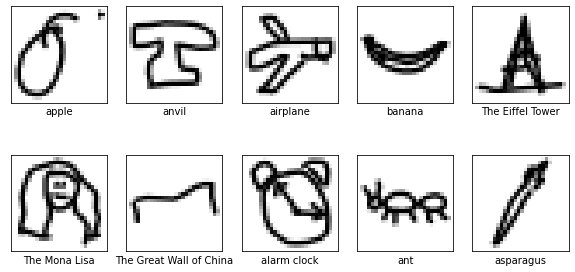

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
start = 0

for num, name in enumerate(class_names):
    plt.subplot(2,5, num+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[start].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(name)
    start += 10000
plt.show() 

In [5]:
from sklearn.utils import shuffle
x_train, y = shuffle(x_train, y)

In [6]:
y

array([0, 0, 6, ..., 8, 2, 4])

In [7]:
x_train = x_train.astype('float32') / 255.
print(x_train.shape)

(100000, 784)


In [8]:
x_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05882353, 0.02352941,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01960784, 0.2627451 , 0.26666668, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.80784315, 0.58431375, 0.        , 0.        ,
       0.        , 0.05882353, 0.34117648, 0.6509804 , 0.93725

In [9]:
%load_ext tensorboard

In [10]:
x_train[0].shape[0]

784

In [11]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(x_train[0].shape[0],))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation="relu")(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(x_train[0].shape[0], activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [12]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [13]:
autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')

In [14]:
import os
import datetime

from tensorflow.keras.callbacks import TensorBoard

stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)

logdir = os.path.join("logs", "simple_autoencoder")
tensorboard = TensorBoard(log_dir=logdir)

autoencoder.fit(x_train, 
                x_train, 
                epochs=100, 
                batch_size=64, 
                shuffle=True, # optinal because we shuffled the data earlier
                validation_split=0.2,
                callbacks=[stop, tensorboard]
                )

Epoch 1/100
   1/1250 [..............................] - ETA: 0s - loss: 0.6938WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2952 - val_loss: 0.2431
Epoch 2/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2335 - val_loss: 0.2285
Epoch 3/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2260 - val_loss: 0.2249
Epoch 4/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2236 - val_loss: 0.2234
Epoch 5/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2226 - val_loss: 0.2228
Epoch 6/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2221 - val_loss: 0.2226
Epoch 7/100
1250/1250 [==============

In [15]:
%tensorboard --logdir=logs

<IPython.core.display.Javascript object>

In [16]:
# encode and decode some digits
# note that we take them from the *test* set

decoded_imgs = autoencoder(x_train)

In [17]:
class_names

['apple',
 'anvil',
 'airplane',
 'banana',
 'The Eiffel Tower',
 'The Mona Lisa',
 'The Great Wall of China',
 'alarm clock',
 'ant',
 'asparagus']

In [18]:
class_names[y[0]]

'apple'

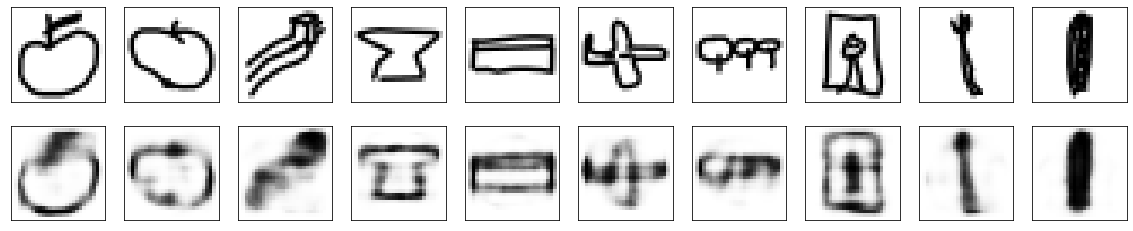

In [19]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap=plt.cm.binary)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].numpy().reshape(28, 28), cmap=plt.cm.binary)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Challenge

Expected to talk about the components of autoencoder and their purpose. 

# Train an Autoencoder (Learn)
<a id="p2"></a>

## Overview

As long as our architecture maintains an hourglass shape, we can continue to add layers and create a deeper network. 

## Follow Along

### Deep Autoencoder

In [20]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [21]:
# compile & fit model

autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')

stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)

logdir = os.path.join("logs", "deeper_autoencoder")
tensorboard = TensorBoard(log_dir=logdir)

autoencoder.fit(x_train, x_train,
                epochs=10000,
                batch_size=64,
                shuffle=True,
                validation_split=.2,
                callbacks=[stop,tensorboard])

Epoch 1/10000
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2874 - val_loss: 0.2528
Epoch 2/10000
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2436 - val_loss: 0.2358
Epoch 3/10000
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2308 - val_loss: 0.2269
Epoch 4/10000
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2233 - val_loss: 0.2222
Epoch 5/10000
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2179 - val_loss: 0.2156
Epoch 6/10000
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2136 - val_loss: 0.2125
Epoch 7/10000
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2099 - val_loss: 0.2091
Epoch 8/10000
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2073 - val_loss: 0.2068
Epoch 9/10000
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2049 - val_loss: 0.2042
Epoch 10/10000
1250/1250 [=============================

In [22]:
%tensorboard --logdir logs/deeper_autoencoder

<IPython.core.display.Javascript object>

In [23]:
decoded_imgs = autoencoder(x_train)

In [24]:
decoded_imgs.shape()

TypeError: ignored

In [ ]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap=plt.cm.binary)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].numpy().reshape(28, 28), cmap=plt.cm.binary)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Convolutional autoencoder

> Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

> Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [27]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model


n_channels = 1 # black&white images
# Create Model 
input_img = Input(shape=(28, 28, n_channels))
encoded = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
encoded = MaxPooling2D((2,2), padding='same')(encoded) 
encoded = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2,2), padding='same')(encoded) 
encoded = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2,2), padding='same')(encoded) # <-- dense vector representation i.e. embedding

decoded = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(8, (3,3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(16, (3,3), activation='relu')(decoded)
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(n_channels, (3,3), activation='sigmoid', padding='same')(decoded)

autoencoder = Model(input_img, decoded)

autoencoder.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 8)          

In [28]:
x_train.shape

(100000, 784)

In [29]:
x_train = x_train.reshape((x_train.shape[0], 28, 28))
x_train.shape

(100000, 28, 28)

In [30]:
autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')

In [31]:
stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)

logdir = os.path.join("logs", "conv_autoencoder")
tensorboard = TensorBoard(log_dir=logdir)

autoencoder.fit(x_train, x_train,
                epochs=10000,
                batch_size=64,
                shuffle=True,
                validation_split=.2,
                callbacks=[stop,tensorboard])

Epoch 1/10000
1250/1250 [==============================] - 8s 7ms/step - loss: 0.2745 - val_loss: 0.2366
Epoch 2/10000
1250/1250 [==============================] - 8s 7ms/step - loss: 0.2281 - val_loss: 0.2237
Epoch 3/10000
1250/1250 [==============================] - 8s 6ms/step - loss: 0.2168 - val_loss: 0.2137
Epoch 4/10000
1250/1250 [==============================] - 8s 7ms/step - loss: 0.2098 - val_loss: 0.2074
Epoch 5/10000
1250/1250 [==============================] - 8s 7ms/step - loss: 0.2044 - val_loss: 0.2020
Epoch 6/10000
1250/1250 [==============================] - 8s 7ms/step - loss: 0.2003 - val_loss: 0.1981
Epoch 7/10000
1250/1250 [==============================] - 8s 7ms/step - loss: 0.1971 - val_loss: 0.1955
Epoch 8/10000
1250/1250 [==============================] - 8s 7ms/step - loss: 0.1946 - val_loss: 0.1940
Epoch 9/10000
1250/1250 [==============================] - 8s 7ms/step - loss: 0.1924 - val_loss: 0.1916
Epoch 10/10000
1250/1250 [=============================

In [32]:
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

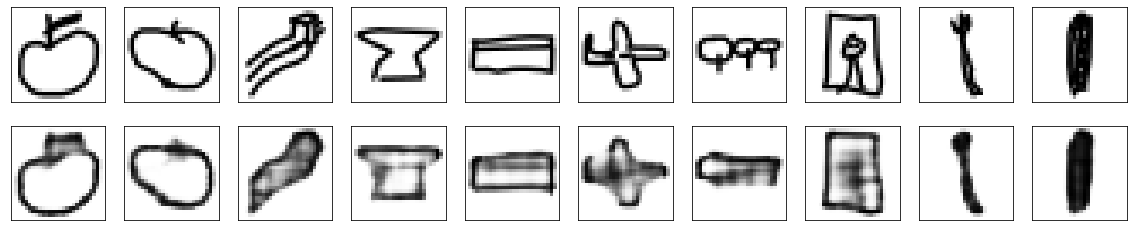

In [33]:
decoded_imgs = autoencoder.predict(x_train)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n +1)
    plt.imshow(decoded_imgs[i].reshape(28,28), cmap=plt.cm.binary)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [34]:
encoder = Model(input_img, encoded)

In [35]:
x_compressed = encoder.predict(x_train)

In [36]:
x_compressed = x_compressed.reshape((x_compressed.shape[0], 128))

In [37]:
x_compressed.shape

(100000, 128)

In [39]:
x_train[2].shape

(28, 28)

In [40]:
x_compressed[2].shape

(128,)

#### Visualization of the Representations

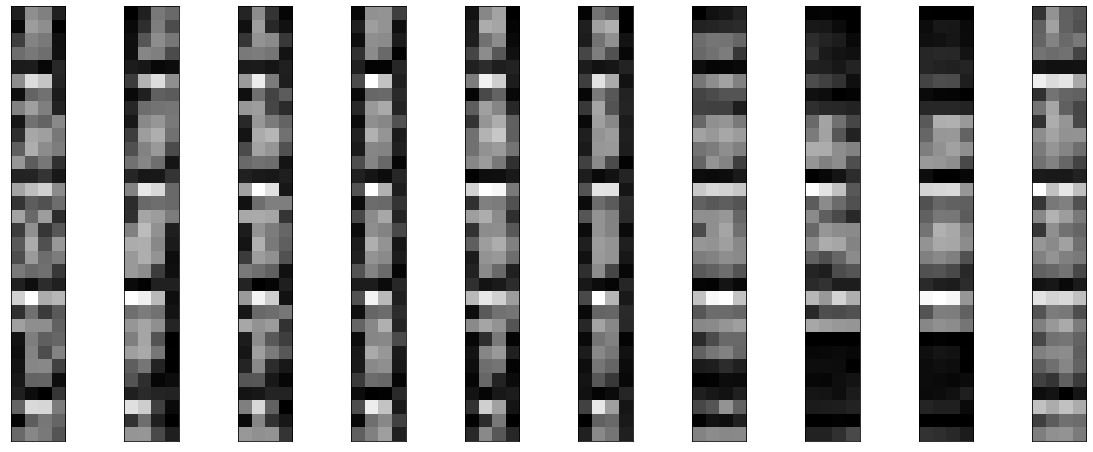

In [38]:
encoder = Model(input_img, encoded)
encoder.predict(x_train)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_compressed[i].reshape(4, 4 * 8  ).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Challenge

You will train an autoencoder at some point in the near future. 

# Information Retrieval with Autoencoders (Learn)
<a id="p3"></a>

## Overview

A common usecase for autoencoders is for reverse image search. Let's try to draw an image and see what's most similiar in our dataset. 

To accomplish this we will need to slice our autoendoer in half to extract our reduced features. :) 

## Follow Along

In [41]:
encoded_imgs = x_compressed

In [42]:
encoded_imgs.shape

(100000, 128)

In [43]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors()
nn.fit(encoded_imgs)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [44]:
class_names

['apple',
 'anvil',
 'airplane',
 'banana',
 'The Eiffel Tower',
 'The Mona Lisa',
 'The Great Wall of China',
 'alarm clock',
 'ant',
 'asparagus']

In [45]:
for i, l in enumerate(y):
  if l == 5:
    print(i)

Streaming output truncated to the last 5000 lines.
50032
50044
50045
50048
50052
50055
50073
50083
50091
50095
50120
50137
50147
50156
50165
50199
50203
50226
50232
50241
50296
50302
50313
50316
50319
50320
50323
50331
50343
50360
50373
50383
50386
50387
50389
50393
50394
50403
50409
50424
50443
50445
50446
50453
50463
50473
50478
50493
50504
50507
50508
50510
50516
50518
50520
50524
50526
50531
50543
50544
50547
50549
50551
50565
50576
50581
50597
50612
50636
50646
50655
50663
50673
50688
50691
50730
50764
50766
50769
50776
50782
50783
50794
50795
50800
50809
50837
50850
50865
50866
50867
50904
50915
50930
50934
50942
50968
50979
50995
50996
51002
51004
51023
51026
51038
51052
51066
51088
51093
51098
51115
51131
51161
51171
51191
51209
51211
51218
51231
51233
51244
51249
51304
51322
51328
51339
51358
51366
51369
51373
51378
51382
51383
51388
51390
51393
51415
51417
51425
51429
51436
51457
51460
51482
51488
51504
51505
51506
51509
51514
51518
51557
51558
51618
51621
51626
51630
51648
5

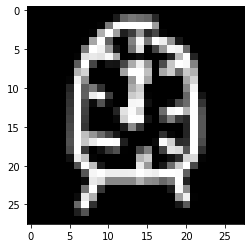

In [46]:
plt.imshow(x_train[98372])

In [47]:
class_names[y[98372]]

'alarm clock'

In [48]:
x_train[98372].shape

(28, 28)

In [49]:
# (28, 28) --> (1, 28, 28, 1)

x = x_train[98372]
x = np.expand_dims(x, axis=0)
x = np.expand_dims(x, axis=-1)
x.shape

(1, 28, 28, 1)

In [50]:
pred = encoder.predict(x)
pred.shape

(1, 4, 4, 8)

In [51]:
preds = nn.kneighbors(pred.reshape(1,128))
preds

(array([[2.55162535e-06, 2.17576525e+00, 2.31525220e+00, 2.42765973e+00,
         2.58815486e+00]]), array([[98372, 10270, 89793, 63646, 41140]]))

alarm clock
alarm clock
alarm clock
alarm clock
The Mona Lisa


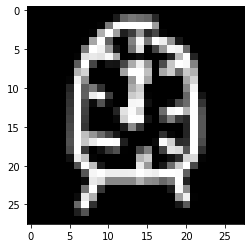

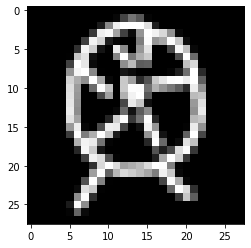

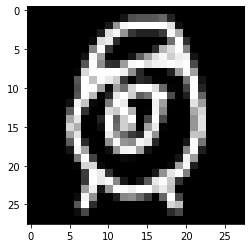

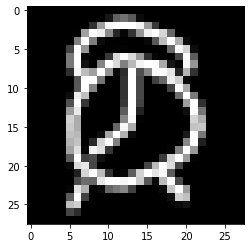

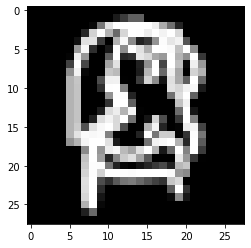

<Figure size 432x288 with 0 Axes>

In [54]:
n = 5

#plt.figure(figsize=(20,10))

for i in range(5):
  ind = preds[1][0][i]
  print(class_names[y[ind]])
  plt.imshow(x_train[ind])
  plt.figure()

## Challenge

You should already be familiar with KNN and similarity queries, so the key component of this section is know what to 'slice' from your autoencoder (the encoder) to extract features from your data. 

# Review

* <a href="#p1">Part 1</a>: Describe the componenets of an autoencoder
    - Encoder
    - Decoder
* <a href="#p2">Part 2</a>: Train an autoencoder
    - Can do in Keras Easily
    - Can use a variety of architectures
    - Architectures must follow hourglass shape
* <a href="#p3">Part 3</a>: Apply an autoenocder to a basic information retrieval problem
    - Extract just the encoder to use for various tasks
    - AE ares good for dimensionality reduction, reverse image search, and may more things. 


# Sources

__References__
- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Deep Learning Cookbook](http://shop.oreilly.com/product/0636920097471.do)

__Additional Material__